In [1]:
import re
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing

# Data loading

In [2]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [3]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

In [4]:
print(dir(dataset0))

['DESCR', 'data', 'filenames', 'target', 'target_names']


data/CroppedYale/yaleB27/yaleB27_P00A-070E+45.pgm
25
yaleB27
2432


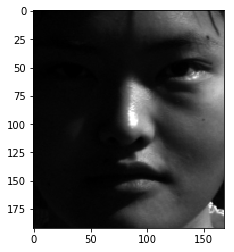

In [5]:
# Here is some sanity checks of the parsed dataset
idx0 = len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0/float(256), plt.cm.gray)

In [6]:
(image0.min(), image0.max())

(0, 255)

In [7]:
# This cell includes the splittign of training and test set.
size0 = 1280
separate = 1024
X = np.stack(map(read_pgm2, dataset0.data))
X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = (X/255.0)*2 - 1
#rescale to -1, 1

y = dataset0.target
y = y[:size0]
#imageX = X[0].reshape((shapeX[1],shapeX[2]))
#plt.imshow(imageX, plt.cm.gray)

print(X.shape, y.shape)

X_train = X[:separate]
y_train = y[:separate]
X_test = X[separate:]
y_test = y[separate:]

(1280, 32256) (1280,)


In [8]:
(X.min(), X.max())

(-1.0, 1.0)

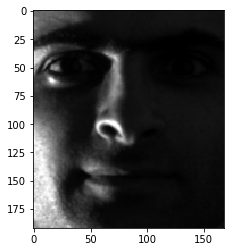

In [9]:
plt.imshow(X[0].reshape((shapeX[1],shapeX[2])), plt.cm.gray)

# RVAE

In [10]:
import networks
from RobustVAE import L0VAE

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


In [31]:
random_seed = 1234

n_in = X.shape[1]
n_cts = 10
n_sparse = 5

encoder = networks.MLP(n_in, n_cts*2+n_sparse, 2, [300,300])
decoder = networks.MLP(n_cts+n_sparse, n_in, 2, [300,300])

l0vae = L0VAE(encoder, decoder, n_cts, n_sparse)

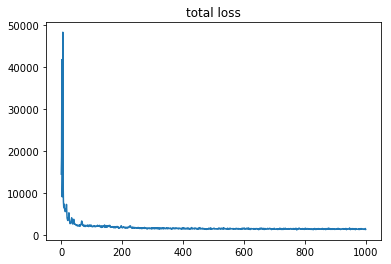

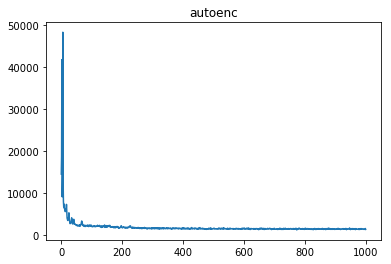

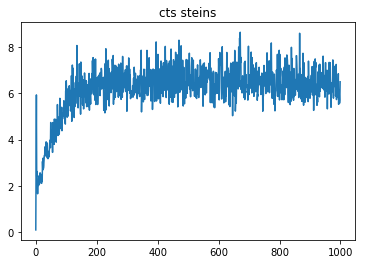

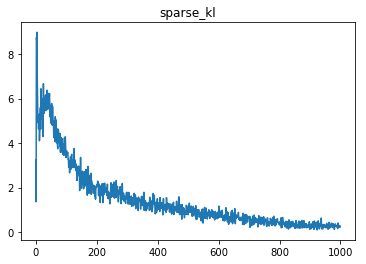

In [32]:
l0vae.train(X, sparsity = .05, iters=1000, batch_size=100, lr=1e-2)

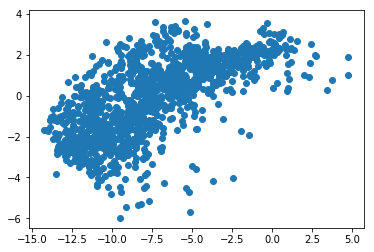

In [71]:
zhat = l0vae.encode(X)
plt.scatter(zhat[:,0], zhat[:,1])

In [72]:
(np.abs(zhat[:, n_cts:] - 1) < .1).astype(int)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ..., 
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0]])

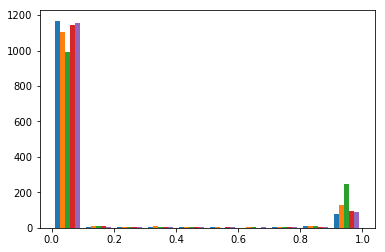

In [73]:
hist = plt.hist(zhat[:, n_cts:])

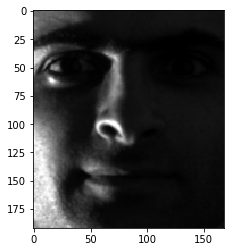

In [74]:
plt.imshow(X[0].reshape((shapeX[1],shapeX[2])), plt.cm.gray)

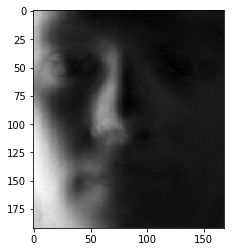

In [75]:
xhat = decoder(zhat)
xhat = l0vae.sess.run(xhat)
plt.imshow(xhat[0].reshape((shapeX[1],shapeX[2])), plt.cm.gray)

In [76]:
z0 = np.copy(zhat[0])
z0[-n_sparse:] = 0

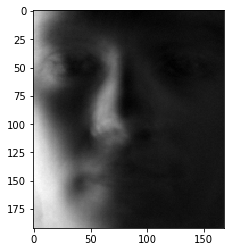

In [77]:
x0new = decoder(np.array([z0]))
x0new = l0vae.sess.run(x0new)
plt.imshow(x0new[0].reshape((shapeX[1],shapeX[2])), plt.cm.gray)

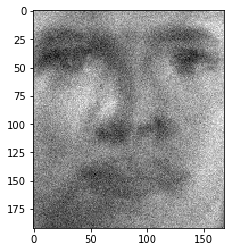

In [87]:
plt.imshow((xhat[0] - x0new[0]).reshape((shapeX[1],shapeX[2])), plt.cm.gray)

In [78]:
import matplotlib.image as mpimg
img=mpimg.imread('data/hudson.png')[:,:,0].reshape(1,shapeX[1]*shapeX[2])

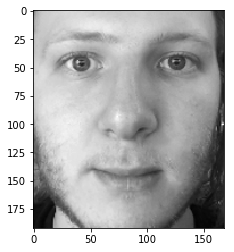

In [79]:
plt.imshow(img.reshape((shapeX[1],shapeX[2])), plt.cm.gray)

In [80]:
imgenc = l0vae.encode(img*2-1)

In [81]:
imghat = l0vae.sess.run(decoder(imgenc))

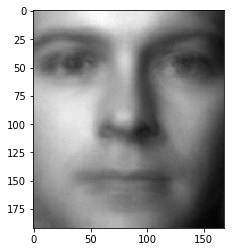

In [82]:
plt.imshow(imghat.reshape((shapeX[1],shapeX[2])), plt.cm.gray)

In [83]:
imgenc2 = np.copy(imgenc)
imgenc2[-n_sparse:] = 0

In [84]:
imghat2 = l0vae.sess.run(decoder(imgenc2))

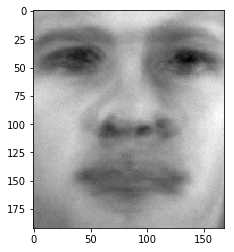

In [85]:
plt.imshow(imghat2.reshape((shapeX[1],shapeX[2])), plt.cm.gray)